In [34]:
# -- IMPORTS START --
import pandas as pd
import glob
import re
import os
import sys
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
# -- IMPORTS END --

# enable zooming into graphs
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

In [35]:
# Helper function to visualize model - Do not modify
def viz_tree(dt_model,features_frames,cnames):
    # Fix feature names as list
    feature_names = features_frames.columns.tolist()

    fig, ax = plt.subplots(figsize=(9,4))
    tree.plot_tree(dt_model,
                   feature_names=feature_names,
                   fontsize=7,
                   class_names=cnames,
                   filled=True,
                   ax=ax)

    plt.title('Decision Tree')
    plt.savefig('dt.png')

In [36]:
def calc_magnitude(data):
    
    # Calculate magnitude
    data['accel_mag'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2) # absolute accel magnitude
    data['accel_mag'] = data['accel_mag'] - data['accel_mag'].mean() # detrend: "remove gravity"

    return data

In [37]:
def remove_noise(data,sampling_rate):
    from scipy.signal import butter, filtfilt, find_peaks

    # Low pass filter
    cutoff = 5 # Hz
    order = 2
    b, a = butter(order, cutoff/(sampling_rate/2), btype='lowpass')
    data['filtered_accel_mag'] = filtfilt(b, a, data['accel_mag'])


    # Peak detection
    peaks, properties = find_peaks(data['filtered_accel_mag'], height=5)  
    data['num_peaks'] = len(peaks) 
    if 'prominences' in properties:
        data['peak_prominence'] = properties['prominences'].mean() if len(properties['prominences']) > 0 else 0
    else:
        data['peak_prominence'] = 0  # If no prominences were calculated, set to 0

    # Safely extract peak distance, ensuring there are enough peaks
    if len(peaks) > 1:
        data['peak_distance'] = np.mean(np.diff(peaks))
    else:
        data['peak_distance'] = 0  # If there are not enough peaks to calculate distance, set to 0

    return data

In [38]:
def clean_data(data):
    # Convert 'num_peaks' to numeric values
    data['num_peaks'] = pd.to_numeric(data['num_peaks'], errors='coerce')

    # Drop rows with missing values
    data = data.dropna()

    # Ensure all columns used for training are numeric
    X = data.drop(columns=['label'])  # Assuming 'label' is your target column
    y = data['label']
    
    return X, y

In [39]:
def add_features(window):
    features = {}
    features['avg'] = window['filtered_accel_mag'].mean()
    features['max'] = window['filtered_accel_mag'].quantile(1)
    features['med'] = window['filtered_accel_mag'].quantile(0.5)
    features['min'] = window['filtered_accel_mag'].quantile(0)
    features['q25'] = window['filtered_accel_mag'].quantile(0.25)
    features['q75'] = window['filtered_accel_mag'].quantile(0.75)
    features['std'] = window['filtered_accel_mag'].std()

    features['num_peaks'] = float(window['num_peaks'].iloc[0])
    features['peak_prominence'] = float(window['peak_prominence'].iloc[0])
    features['peak_distance'] = float(window['peak_distance'].iloc[0])

    df = pd.DataFrame()
    df = df._append(features,ignore_index=True)
    return df

In [40]:
def extract_features(data, window_sec, sample_rate):
    if 'time' in data.columns:
        data['time'] = pd.to_datetime(data['time'])
        data = data.set_index('time')

    frame_list = []
    sample_count = int(window_sec * sample_rate)

    for t, window in data.resample(f"{window_sec}S"):
        if len(window) < sample_count:
            continue

        frame = {}
        frame['time'] = t

        # Extract features using helper function
        features = add_features(window)
        for feature_name, feature_value in features.items():
            frame[feature_name] = feature_value

        # Append the frame to the list
        frame_list.append(frame)

    resampled_data = pd.DataFrame(frame_list)
    return resampled_data

In [41]:
def all_data_to_combined_csv(root, output_filename='pilates_data.csv'):
    all_data = pd.DataFrame()

    files = glob.glob(os.path.join(root, '**', '*.csv'), recursive=True)

    for file in files:
        # Determine sensor type
        if 'accelerometer' in file.lower():
            sensor_type = 'accelerometer'
        elif 'gyroscope' in file.lower():
            sensor_type = 'gyroscope'
        else:
            print(f"Skipping unknown file type: {file}")
            continue

        # Read the CSV file
        df = pd.read_csv(file)

        # Calculate magnitude and remove noise
        sampling_rate = 100
        window_sec = 5  # Set desired time window for feature extraction
        df = calc_magnitude(df)
        df = remove_noise(df, sampling_rate)

        # Extract metadata from file path
        parts = os.path.normpath(file).split(os.sep)
        exercise = parts[-3]
        pace_raw = parts[-2]

        pace = pace_raw.split('-')[0]

        # Extract features
        features = extract_features(df, window_sec=window_sec, sample_rate=sampling_rate)

        # Add metadata to the features DataFrame
        features['exercise'] = exercise
        features['pace'] = pace
        features['sensor_type'] = sensor_type

        # Append features to all_data
        all_data = pd.concat([all_data, features], ignore_index=True)


    # Save the combined data to a CSV
    output_path = os.path.join(root, output_filename)
    all_data.to_csv(output_path, index=False)
    print(f"Combined data saved to {output_path}")

In [42]:
def train_decision_tree(frames):
    # Extract feature columns
    X = frames[['avg', 'max', 'med', 'min', 'q25', 'q75', 'std']]

    # Extract target column
    y = frames['pace']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Create model
    dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=5)
    dt_model.fit(X_train, y_train)

    # Predict on test set
    dt_pred = dt_model.predict(X_test)

    # Evaluate on test set
    acc = dt_model.score(X_test, y_test)

    # Print classification report
    print(classification_report(y_test, dt_pred))
    print("Accuracy on test set:", acc)

    return dt_model, acc

In [43]:
def transform_time_to_datetime(root):
    
    dateparse = lambda dates: [pd.to_datetime(d, unit='ns') for d in dates]
    # Get list of all activity folders
    activity_folders = os.listdir(root)
    # print(activity_folders)

    for folder in activity_folders:
        # print(folder)
        files = glob.glob(f"{root}/{folder}/*.csv")
        for filename in files:
            # print(filename)
            df = pd.read_csv(filename, parse_dates=['time'])
            df['time'] = pd.to_datetime(pd.to_numeric(df['time']), unit='ns')
            df.to_csv(filename, index=False)

In [44]:
transform_time_to_datetime('./data')

all_data_to_combined_csv(root='./data')

Skipping unknown file type: ./data\pilates_data.csv


C:\Users\helen\AppData\Local\Temp\ipykernel_7152\1536113829.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t, window in data.resample(f"{window_sec}S"):
C:\Users\helen\AppData\Local\Temp\ipykernel_7152\1536113829.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t, window in data.resample(f"{window_sec}S"):
C:\Users\helen\AppData\Local\Temp\ipykernel_7152\1536113829.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t, window in data.resample(f"{window_sec}S"):
C:\Users\helen\AppData\Local\Temp\ipykernel_7152\1536113829.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t, window in data.resample(f"{window_sec}S"):
C:\Users\helen\AppData\Local\Temp\ipykernel_7152\1536113829.py:9: FutureWarning: 'S' is deprecated and will be removed in a future versi

Skipping unknown file type: ./data\exercise 4\correct-2024-12-10_17-25-28\Metadata.csv
Skipping unknown file type: ./data\exercise 4\correct-2024-12-10_17-25-28\Pedometer.csv
Combined data saved to ./data\pilates_data.csv


In [45]:
data = pd.read_csv('./data/pilates_data.csv')

data['pace'] = data['pace'].map({'correct': 0, 'incorrect': 1})
feature_columns = ['avg', 'max', 'med', 'min', 'q25', 'q75', 'std']
data[feature_columns] = data[feature_columns].apply(
    lambda x: x.str.replace(r'^\d+\s+', '', regex=True) 
                .str.replace(r'\nName:.*', '', regex=True) 
                .astype(float)
)

print(data[feature_columns].head())

        avg       max       med       min       q25       q75       std
0  0.052472  0.565334  0.005242 -0.147098 -0.057099  0.140659  0.152178
1 -0.036790  0.175787 -0.048947 -0.174527 -0.116838  0.024374  0.089257
2 -0.001080  0.355251 -0.013210 -0.206610 -0.083554  0.077209  0.116366
3 -0.077643  0.126584 -0.088567 -0.158944 -0.119217 -0.050984  0.054724
4  0.076930  0.629554  0.047907 -0.170778 -0.039719  0.183261  0.150639


In [46]:
def evaluate(dt_model, data):
    X_test = data[['avg', 'max', 'med', 'min', 'q25', 'q75', 'std']]

    # Extract target column
    y_test = data['pace']

    dt_pred = dt_model.predict(X_test)
    # Evaluate on test set
    acc = dt_model.score(X_test, y_test)
    dt_cm = confusion_matrix(y_test, dt_pred, labels=dt_model.classes_)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=["Correct Pace", "Incorrect Pace"])
    cm_display.plot(cmap="Blues", values_format="d")
    plt.show()

    print(classification_report(y_test, dt_pred))
    print("Accuracy on test set:", acc)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91        29
           1       0.83      0.95      0.89        21

    accuracy                           0.90        50
   macro avg       0.90      0.91      0.90        50
weighted avg       0.91      0.90      0.90        50

Accuracy on test set: 0.9


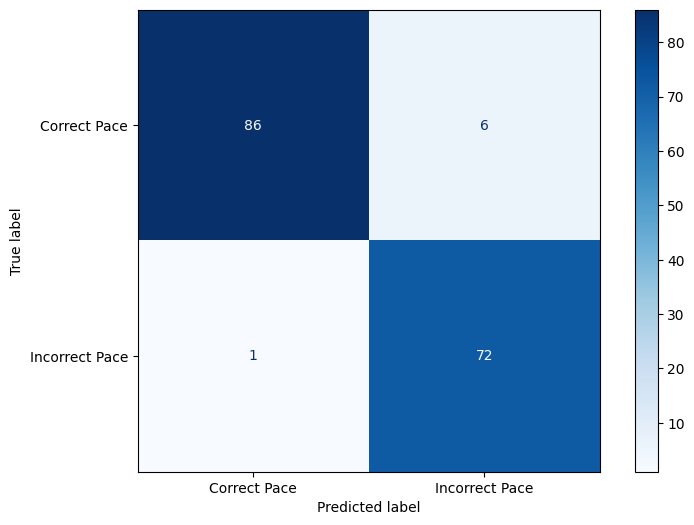

              precision    recall  f1-score   support

           0       0.99      0.93      0.96        92
           1       0.92      0.99      0.95        73

    accuracy                           0.96       165
   macro avg       0.96      0.96      0.96       165
weighted avg       0.96      0.96      0.96       165

Accuracy on test set: 0.9575757575757575


In [47]:
dt_model, acc = train_decision_tree(data)
evaluate(dt_model, data)

In [48]:
# Train on the entire dataset and evaluate using cross-validation
X = data[['avg', 'max', 'med', 'min', 'q25', 'q75', 'std']]
y = data['pace']
model = DecisionTreeClassifier(max_depth=5, criterion='entropy')

# 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

Cross-validation scores: [0.78787879 0.96969697 0.57575758 0.90909091 0.87878788]
Average cross-validation score: 0.8242424242424242


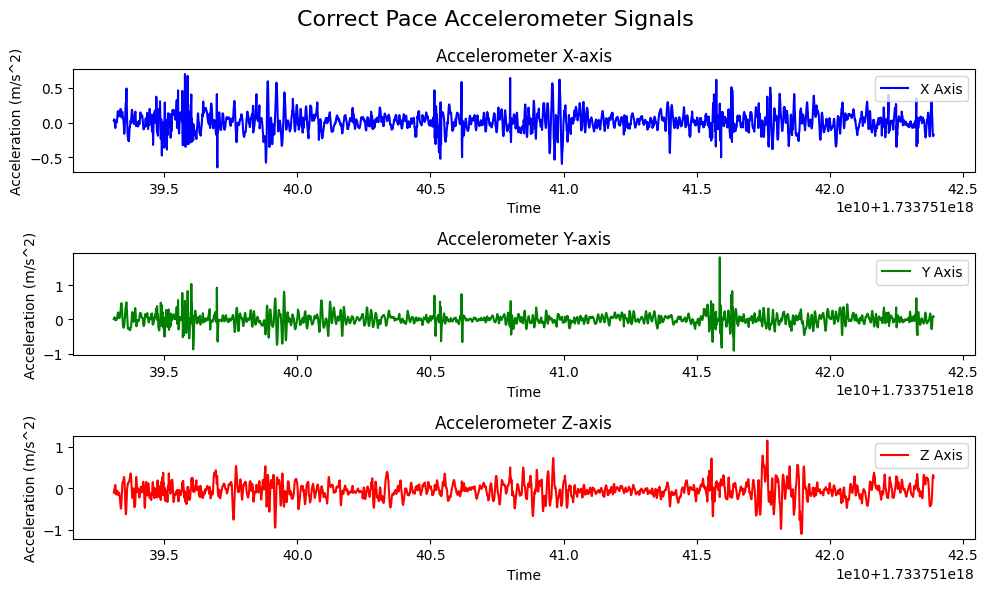

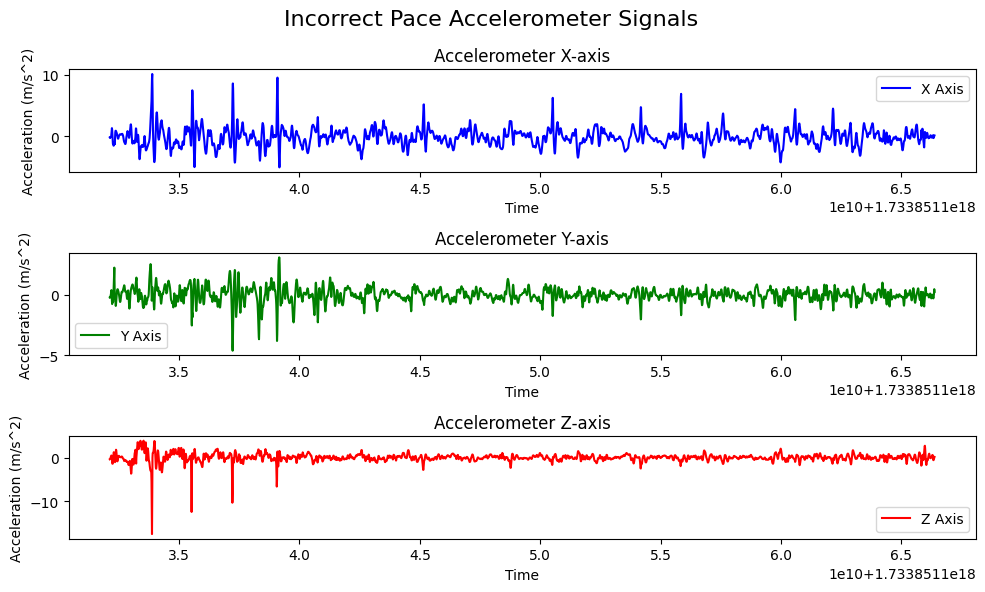

In [49]:
# Plotting Correct Accelerometer Signal

accelerometer_data = pd.read_csv('./data/exercise 1/correct-2024-12-09_13-36-33/Accelerometer.csv')

# Create a DataFrame for accelerometer data
accelerometer_df = pd.DataFrame(accelerometer_data)

# Plot accelerometer signals (x, y, z)
plt.figure(figsize=(10, 6))
plt.suptitle('Correct Pace Accelerometer Signals', fontsize=16)

plt.subplot(3, 1, 1)
plt.plot(accelerometer_df['time'], accelerometer_df['x'], label='X Axis', color='blue')
plt.title('Accelerometer X-axis')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(accelerometer_df['time'], accelerometer_df['y'], label='Y Axis', color='green')
plt.title('Accelerometer Y-axis')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(accelerometer_df['time'], accelerometer_df['z'], label='Z Axis', color='red')
plt.title('Accelerometer Z-axis')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.tight_layout()
plt.show()


# Plotting Incorrect Accelerometer Signal

incorrect_accel = pd.read_csv('./data/exercise 1/incorrect-2024-12-10_17-18-52/Accelerometer.csv')

# Create a DataFrame for accelerometer data
accelerometer2_df = pd.DataFrame(incorrect_accel)

# Plot accelerometer signals (x, y, z)
plt.figure(figsize=(10, 6))
plt.suptitle('Incorrect Pace Accelerometer Signals', fontsize=16)


plt.subplot(3, 1, 1)
plt.plot(accelerometer2_df['time'], accelerometer2_df['x'], label='X Axis', color='blue')
plt.title('Accelerometer X-axis')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(accelerometer2_df['time'], accelerometer2_df['y'], label='Y Axis', color='green')
plt.title('Accelerometer Y-axis')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(accelerometer2_df['time'], accelerometer2_df['z'], label='Z Axis', color='red')
plt.title('Accelerometer Z-axis')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.tight_layout()
plt.show()